# Approximate posteriors for source parameters

__last update__: 29/11/21

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
from astropy.io import fits
import corner
import seaborn as sns # for nicer colors on the plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('image', interpolation='none')

In [2]:
SAVE_FIGURES = False

# Factor of pixel scale for the potential grid
potential_pixel_scale = 4

# What results (stored in fits files) do consider
choices = [
    ('dark halo', f'fisher-dark_halo-scale_{potential_pixel_scale}-smooth_source.fits'),
    ('GRF', f'fisher-GRF-scale_{potential_pixel_scale}-smooth_source.fits'),
    ('discyness', f'fisher-discyness-scale_{potential_pixel_scale}-smooth_source.fits'),
]
choices_fully_smooth = [
    ('dark halo (analytical fit)', 'fisher-dark_halo-fully_smooth_fit-smooth_source.fits'),
    ('GRF (analytical fit)', 'fisher-GRF-fully_smooth_fit-smooth_source.fits'),
    ('discyness (analytical fit)', 'fisher-discyness-fully_smooth_fit-smooth_source.fits'),
]

In [3]:
def get_samples(results_list, full_fisher=True):
    samples_list = []
    for res in results_list:
        res_label, filename = res
        with fits.open(os.path.join('results', filename)) as hdus:
            idx1, idx2 = hdus[0].header['SRCIDX1'], hdus[0].header['SRCIDX2']
    
            if full_fisher:
                # full covariance matrix
                cov = hdus[0].data[idx1:idx2, idx1:idx2]
            else:
                # 'all-fixed-but-the-source' covariance matrix
                cov = hdus[1].data

            mean = hdus[2].data['bestfit'][idx1:idx2]
            truths = hdus[2].data['input'][idx1:idx2]
            labels = hdus[2].data['symbols'][idx1:idx2]

        samples = np.random.multivariate_normal(mean, cov, size=10000)
        samples_list.append(samples)
    return samples_list, truths, labels

samples_list, truths, labels = get_samples(choices, full_fisher=False)
samples_list_fs, _, _ = get_samples(choices_fully_smooth, full_fisher=True)

/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: covariance is not positive-semidefinite.


In [15]:
def add_values_indic_to_corner(fig, values, color='green', linewidth=1, linestyle='-', 
                               markersize=10, marker='s', label=None, reverse=False):
    # Extract the axes
    ndim = len(values)
    axes = np.array(fig.axes).reshape((ndim, ndim))
    # Loop over the diagonal
    for i in range(ndim):
        if reverse:
            ax = axes[ndim - i - 1, ndim - i - 1]
        else:
            ax = axes[i, i]
        if values[i] is not None:
            ax.axvline(values[i], color=color, linewidth=linewidth, linestyle=linestyle, label=label)
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            if reverse:
                ax = axes[ndim - yi - 1, ndim - xi - 1]
            else:
                ax = axes[yi, xi]
            if values[xi] is not None:
                ax.axvline(values[xi], color=color, linewidth=linewidth, linestyle=linestyle)
            if values[yi] is not None:
                ax.axhline(values[yi], color=color, linewidth=linewidth, linestyle=linestyle)
            if values[xi] is not None and values[yi] is not None:
                ax.plot(values[xi], values[yi], color=color, marker=marker, markersize=markersize)

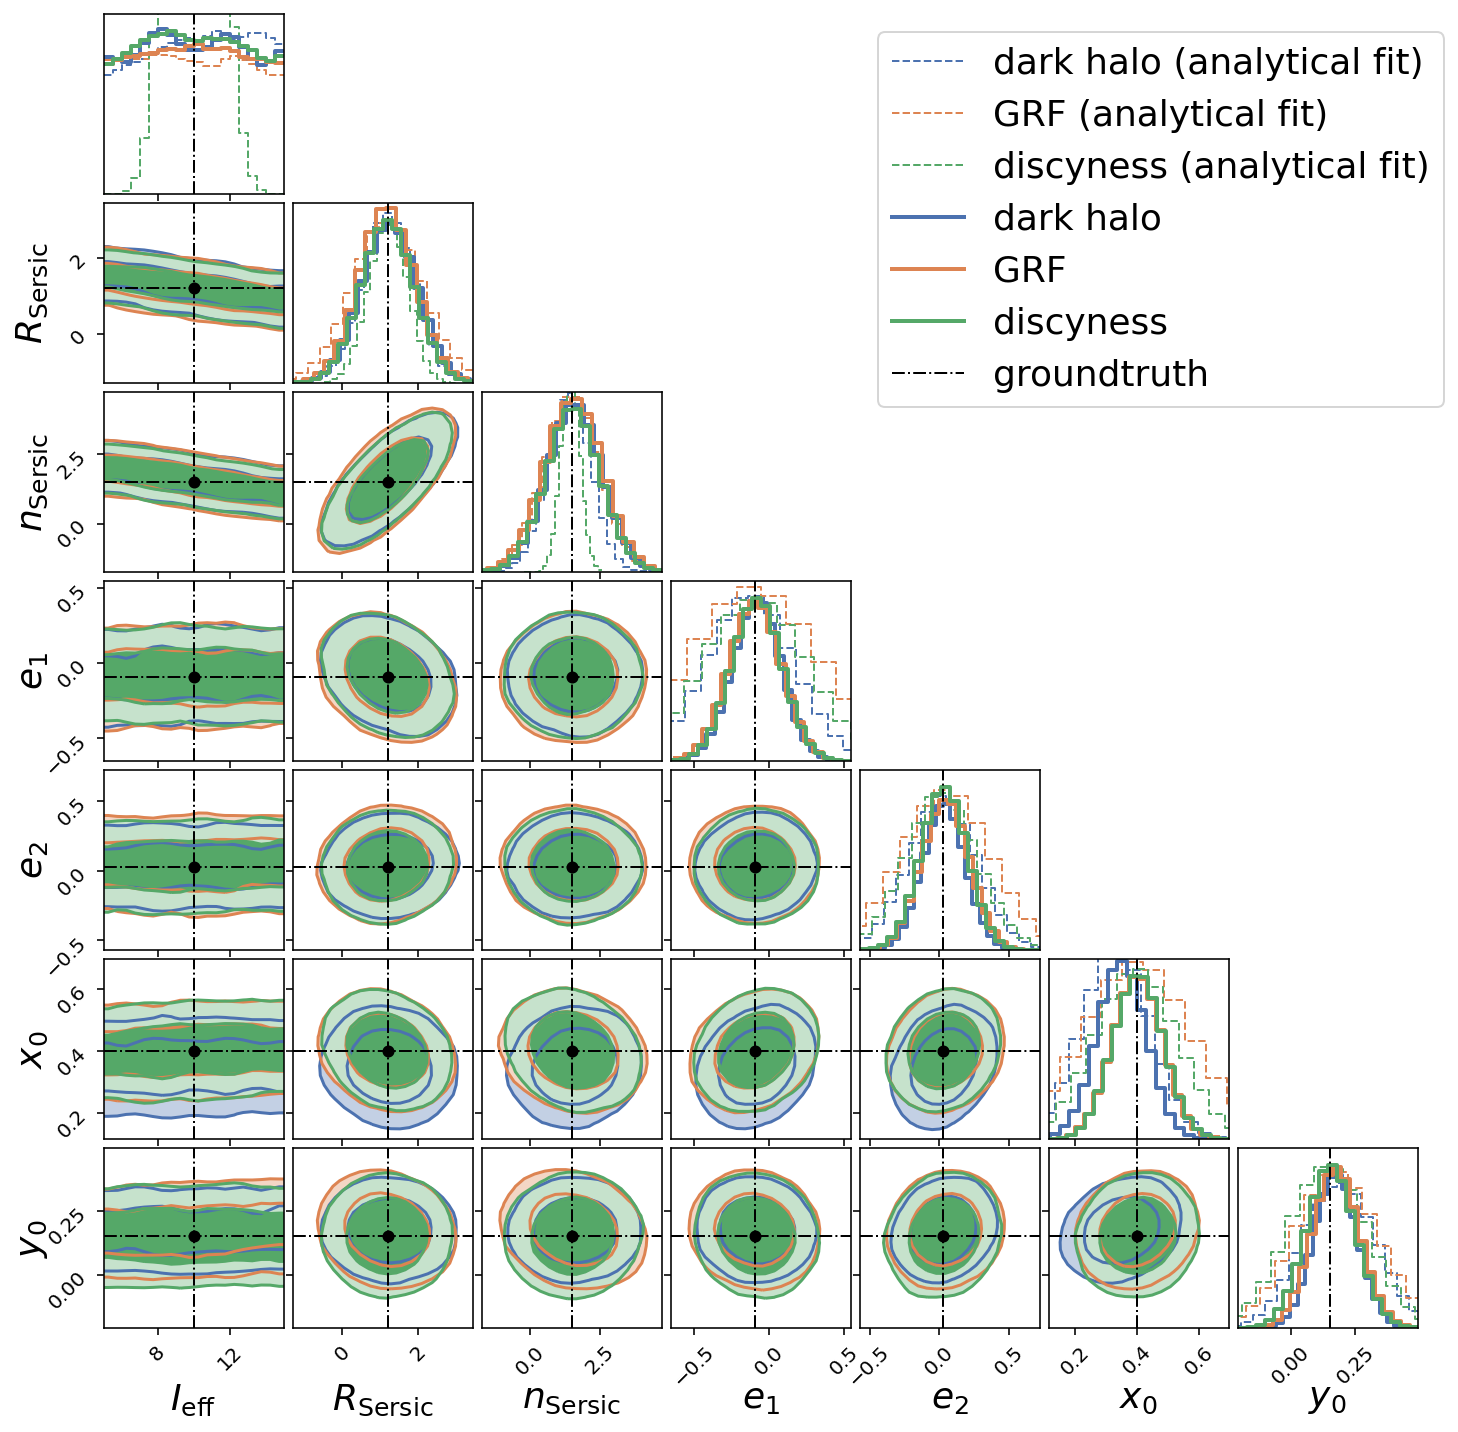

In [16]:
# just replace the symbols of the amplitude
labels[0] = '$I_{\\rm eff}$'

color_list = sns.color_palette("deep", len(samples_list)).as_hex()
#limits = [(5, 15), 1, 1, 1, 1, 1, 1]
limits = [(5, 15), (1), 1, 1, 1, 1, 1]
kwargs_corner = dict(
    max_n_ticks=3, show_titles=False,
    smooth1d=0.99, smooth=0.99,
    levels=(0.68, 0.95), 
    labels=labels, range=limits,
    plot_datapoints=False, plot_density=False,
    plot_contours=True, fill_contours=True, 
    hist_kwargs={'alpha': 1},
    label_kwargs={'fontsize': 18},  #title_kwargs={'fontsize': 18}
)

fig = plt.figure(figsize=(10, 10))
for i in range(len(choices_fully_smooth)):
    kwargs_corner['hist_kwargs'].update({
        'color': color_list[i], 
        'label': choices_fully_smooth[i][0], 
        'linestyle': '--', 
        'linewidth': 1,
    })
    kwargs_corner.update({'plot_contours': False, 'fill_contours': False})
    fig = corner.corner(samples_list_fs[i], fig=fig, 
                        color=color_list[i], **kwargs_corner)
for i in range(len(choices)):
    kwargs_corner['hist_kwargs'].update({
        'color': color_list[i], 
        'label': choices[i][0], 
        'linestyle': '-', 
        'linewidth': 2,
    })
    kwargs_corner.update({'plot_contours': True, 'fill_contours': True})
    fig = corner.corner(samples_list[i], fig=fig, 
                        color=color_list[i], **kwargs_corner)
add_values_indic_to_corner(fig, truths, color='black', markersize=5, marker='o',
                           linestyle='-.', linewidth=1, label="groundtruth")
fig.axes[4].legend(*fig.axes[0].get_legend_handles_labels(), loc='upper left', fontsize=18)
plt.show()

In [17]:
if SAVE_FIGURES:
    figure_dir = os.path.join('figures', 'source parameters')
    figure_name = 'corner_source_params.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight')